<a href="https://colab.research.google.com/github/malraharsh/temp2/blob/master/Experiments_Skin_Classifier_Image_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
DO_GET_Images = True

# Setup

In [2]:
#@title Importing Libraries

import numpy as np
import os

import pandas as pd
import shutil
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from sklearn.model_selection import train_test_split
import shutil
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import scipy.ndimage
from scipy import misc
from glob import glob
from scipy import stats
from sklearn.preprocessing import LabelEncoder, StandardScaler
import skimage
import imageio
import seaborn as sns
from PIL import Image
import glob
import matplotlib.pyplot as plt
import matplotlib

import os
import cv2
import requests
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import vgg16
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
# import scikitplot as skplt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%matplotlib inline

In [3]:
# shutil.make_archive('tfrecord', 'zip', 'tfrecord')

In [4]:
# !cp tfrecord.zip /content/drive/MyDrive/Internship/tfrecord.zip

In [5]:
#@title
%mkdir -p others data

In [6]:
path_drive_data = '/content/drive/MyDrive/Internship/'

In [7]:
# shutil.rmtree(path_images)

In [8]:
%%capture
if DO_GET_Images:
    !cp -n '/content/drive/MyDrive/Internship/Images-Full-Combined.rar' /content/others/
    if not os.path.isdir('/content/Images'):
        !unrar x '/content/others/Images-Full-Combined.rar'

In [9]:
!cp -n /content/drive/MyDrive/Internship/*.csv /content/data/
!cp -n '/content/drive/MyDrive/Internship/tfrecord.zip.zip' /content/others/

cp: cannot stat '/content/drive/MyDrive/Internship/tfrecord.zip.zip': No such file or directory


In [10]:
%%capture
if not os.path.isdir('/content/tfrecord'):
    !unzip -o '/content/others/tfrecord.zip.zip' -d 'tfrecord'

In [11]:
path_data = '/content/Images'

In [12]:
labels = ['Acne', 'Alopecia', 'Chancroid', 'Contact Dermatitis', 
          'Corns and Calluses', 'Distal-Subungual-Onychomycosis', 
          'Drug Eruption', 'Folliculitis', 'Genital Warts', 
          'Guttate Psoriasis', 'Halo Nevus', 'Hemangioma',
          'Herpes Simplex', 'Ichthyosis', 'Impetigo', 'Keloid Scar', 
          'Leprosy', 'Litchen Planus', 'Litchen Simplex Chronicus', 
          'Melasma', 'Molluscum Contagiosum', 'Nummular Dermatitis',
          'Onychomycosis', 'Photocontact Dermatitis', 'Pityriasis Alba',
          'Pityriasis Rosea', 'Pityriasis Versicolor', 'Plaque Psoriasis',
          'Polymorphic Light Eruption', 'Ringworm of Body',
          'Ringworm of Face', 'Ringworm of Hands', 'Ringworm of Scalp',
          'Scabies', 'Seborrheic Dermatitis', 'Syphilis', 'Tinea Cruris',
          'Urticaria', 'Vitiligo', 'Warts']

labels = ['Onychomycosis', 'Photocontact Dermatitis', 'Vitiligo', 'Ichthyosis', 'Impetigo', 'Keloid Scar']

In [13]:
path_root = '/content/'
path_dest = '/content/destination'
path_train = path_root + 'train'
path_test = path_root + 'test'
path_images = 'Images/'

In [14]:
for label in os.listdir(path_images):
    if label in labels: continue
    p = os.path.join(path_images, label)    
    shutil.rmtree(p)

In [15]:
path_images_csv = '/content/data/df_path_images.csv'
if os.path.isfile(path_images_csv):
    df_path_images = pd.read_csv(path_images_csv)
else:
    df_path_images = pd.DataFrame({'disease': [], 'path': []})
    for path_img in glob.glob('Images/*/*.jpg'):
        path_split = path_img.split('/')
        disease = path_split[1]
        path_img = '/'.join(path_split[1:])
        df_path_images = df_path_images.append(dict(disease=disease, path=path_img), ignore_index=True)

In [16]:
# balance
from sklearn.utils import resample#split data into test and training sets

def upsample_data(df, by='Skin Problem'):
    # by - using by skin problem, so count is same, data balancing
    # cols - unique values in by
    cols = df[by].unique()
    max_count = max(df[by].value_counts()) # larget category
    df_up = pd.DataFrame() # upsampled
    for col in cols:
        df_col = df.loc[df[by]==col] # data of particular disease
        upsampled = resample(df_col, replace=True, n_samples=max_count, random_state=42)
        df_up = pd.concat([df_up, upsampled])
    return df_up

In [17]:
preprocess_input_image = tf.keras.applications.mobilenet.preprocess_input

# Start

In [22]:
df = df_path_images.copy()

In [23]:
df = df[df.disease.isin(labels)]
df = df.reset_index()

In [24]:
cnts = df.disease.value_counts()
import math

In [25]:
### removing dis having less than n images

min_images = 0
disease_drop = cnts[cnts < min_images].index
idx_drop = df[df.disease.isin(disease_drop)].index
df.drop(index=idx_drop, inplace=True)
df_orig = df.copy()

In [26]:
labels = sorted(df.disease.unique())

In [27]:
### removing more than keep num images, for class balance

def keep_n_images(keep_n, df):
    for label in labels:
        print(label)
        idxs = df[df.disease == label].index
        idxs_drop = idxs[keep_n:]
        print(len(idxs))
        df = df.drop(index=idxs_drop)
    return df

In [28]:
df.disease.value_counts()

Impetigo                   437
Keloid Scar                379
Ichthyosis                 320
Photocontact Dermatitis    231
Onychomycosis              231
Vitiligo                   171
Name: disease, dtype: int64

In [29]:
df_data = df

# Image

In [30]:
# df_data = keep_n_images(100, df_data)

df_train, df_val = train_test_split(df_data, test_size=0.15,
                                    random_state=42, 
                                    stratify=df_data['disease'])

df_train = upsample_data(df_train, by='disease')

df_test = df_val

In [31]:
batch_size = 32

num_train_samples = len(df_train)
num_test_samples = len(df_test)
train_batch_size = batch_size
test_batch_size = batch_size
image_shape = (224, 224)

In [32]:
train_steps = np.ceil(num_train_samples / train_batch_size)
test_steps = np.ceil(num_test_samples / test_batch_size)

In [62]:
def get_batches_train(shuffle=True):
    datagen_train = ImageDataGenerator(
            rotation_range=30,
            # rescale=1. / 255,
            width_shift_range=0.3,
            height_shift_range=0.3,
            zoom_range=0.3,
            horizontal_flip=True,
            # vertical_flip=True,
            # brightness_range=(0.9,1.1),
            fill_mode='nearest',
            preprocessing_function= preprocess_input_image)

    batches_train = datagen_train.flow_from_dataframe(
                                    dataframe=df_train,
                                    directory=path_data,
                                    x_col='path',
                                    y_col='disease',
                                    # subset="training",
                                    batch_size=train_batch_size,
                                    seed=42,
                                    shuffle=shuffle,
                                    # class_mode="categorical",
                                    target_size=image_shape)

    return batches_train

def get_batches_test(df_test=df_test):        
    datagen_test = ImageDataGenerator(
                                    #   rescale=1. / 255,
                                      preprocessing_function= preprocess_input_image)

    batches_test = datagen_test.flow_from_dataframe(
                                    dataframe=df_test,
                                    directory=path_data,
                                    x_col='path',
                                    y_col='disease',
                                    # subset="training",
                                    batch_size=test_batch_size,
                                    seed=42,
                                    shuffle=False,
                                    # class_mode="categorical",
                                    target_size=image_shape)
    
    return batches_test

batches_train = get_batches_train()
batches_test = get_batches_test()

Found 2232 validated image filenames belonging to 6 classes.
Found 266 validated image filenames belonging to 6 classes.


In [34]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(batches_train.classes),
                                                 batches_train.classes)
class_weights = dict(enumerate(class_weights))

In [35]:
path_images = 'Images/'
# nb_images=len(tf.io.gfile.glob(path_images + '*/*.jpg'))
nb_images = df_data.shape[0]
print(tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE # used in tf.data.Dataset API

CLASSES = [file.encode() for file in labels]
# nb_images=len(tf.io.gfile.glob('data/*/*.jpeg'))
SHARDS = 16
shared_size = math.ceil(1.0 * nb_images / SHARDS) # batch size of tfrecord
# print(shared_size)

TARGET_SIZE=224

path_images_train = path_images + df_train.path.values

2.4.1


# TFRecord

In [36]:
import math

def read_image_and_label(img_path):
  
  bits = tf.io.read_file(img_path)
  image = tf.image.decode_jpeg(bits)
  image = tf.image.resize(image, [TARGET_SIZE, TARGET_SIZE])

  label = tf.strings.split(img_path, sep='/')[-2]
#   assert(len(label) > 1) # to make sure sep is correct
  return image, label

dataset = tf.data.Dataset.list_files(path_images_train, seed=10000) # This also shuffles the images
dataset = dataset.map(read_image_and_label)

In [37]:
def compress_image(image, label):
  image = tf.cast(image, tf.uint8)
  image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
  return image, label

dataset = dataset.map(compress_image, num_parallel_calls=AUTO)
dataset = dataset.batch(shared_size) 

def _bytestring_feature(list_of_bytestrings):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=list_of_bytestrings))

def _int_feature(list_of_ints): # int64
  return tf.train.Feature(int64_list=tf.train.Int64List(value=list_of_ints))

def _float_feature(list_of_floats): # float32
  return tf.train.Feature(float_list=tf.train.FloatList(value=list_of_floats))

def to_tfrecord(img_bytes, label):  
  class_num = np.argmax(np.array(CLASSES)==label) 
  feature = {
      "image": _bytestring_feature([img_bytes]), # one image in the list
      "class": _int_feature([class_num]),        # one class in the list      
  }
  return tf.train.Example(features=tf.train.Features(feature=feature))


In [38]:
DO_TFRecord = True
# DO_TFRecord = False
if DO_TFRecord or not os.path.exists('tfrecord'):
    if os.path.exists('tfrecord'): shutil.rmtree('tfrecord')
    os.mkdir('tfrecord')
    for shard, (image, label) in enumerate(dataset):
        shard_size = image.numpy().shape[0]
        filename = "tfrecord/" + "{:02d}-{}.tfrec".format(shard, shard_size)

        with tf.io.TFRecordWriter(filename) as out_file:
            for i in range(shard_size):
            #       print(label.numpy()[i])  
                example = to_tfrecord(image.numpy()[i],label.numpy()[i])
                out_file.write(example.SerializeToString())
        print("Wrote file {} containing {} records".format(filename, shard_size))

Wrote file tfrecord/00-111.tfrec containing 111 records
Wrote file tfrecord/01-111.tfrec containing 111 records
Wrote file tfrecord/02-111.tfrec containing 111 records
Wrote file tfrecord/03-111.tfrec containing 111 records
Wrote file tfrecord/04-111.tfrec containing 111 records
Wrote file tfrecord/05-111.tfrec containing 111 records
Wrote file tfrecord/06-111.tfrec containing 111 records
Wrote file tfrecord/07-111.tfrec containing 111 records
Wrote file tfrecord/08-111.tfrec containing 111 records
Wrote file tfrecord/09-111.tfrec containing 111 records
Wrote file tfrecord/10-111.tfrec containing 111 records
Wrote file tfrecord/11-111.tfrec containing 111 records
Wrote file tfrecord/12-111.tfrec containing 111 records
Wrote file tfrecord/13-111.tfrec containing 111 records
Wrote file tfrecord/14-111.tfrec containing 111 records
Wrote file tfrecord/15-111.tfrec containing 111 records
Wrote file tfrecord/16-111.tfrec containing 111 records
Wrote file tfrecord/17-111.tfrec containing 111 

In [39]:
#@title Visualization Utitlites
# numpy and matplotlib defaults
np.set_printoptions(threshold=15, linewidth=80)
# https://www.kaggle.com/mgornergoogle/getting-started-with-100-flowers-on-tpu
def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(15,15))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()
    
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

In [40]:

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) #/ 255.0
    image = preprocess_input_image(image)
    # image = tf.reshape(image, [TARGET_SIZE,TARGET_SIZE, 3])
    return image


def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64),   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)   
    image = decode_image(example['image']) 
    class_label = tf.cast(example['class'], tf.int32)
    # label = tf.one_hot(label, NUM_CLASSES)
    return image, class_label

def data_augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    # image = tf.image.rot90(image, k=1) # rotate 90º
    # image = tf.image.random_crop(image, (200, 200, 3))
    image = tf.image.random_brightness(image, max_delta=.3)
    # image = tf.image.random_jpeg_quality(image, 70, 100)
    return image, label

def get_batched_dataset(filenames, augment=False, shuffle=False):
  option_no_order = tf.data.Options()
  option_no_order.experimental_deterministic = False

  dataset = tf.data.Dataset.list_files(filenames)
  dataset = dataset.with_options(option_no_order)
  dataset = dataset.interleave(tf.data.TFRecordDataset, cycle_length=16, num_parallel_calls=AUTO)
  dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
  if augment == True:
    dataset = dataset.map(data_augment, num_parallel_calls=AUTOTUNE)
#   dataset = dataset.cache() # This dataset fits in RAM
  dataset = dataset.repeat()
  if shuffle:
    dataset = dataset.shuffle(2048)
  dataset = dataset.batch(BATCH_SIZE) #, drop_remainder=True) # drop_remainder will be needed on TPU
  
  dataset = dataset.prefetch(AUTO) 
  return dataset
  

def get_training_dataset(augment=True):
  return get_batched_dataset(training_filenames, shuffle=True, augment=augment)

def get_validation_dataset():
  return get_batched_dataset(validation_filenames)

AUTO = AUTOTUNE = tf.data.experimental.AUTOTUNE

In [41]:
# training_dataset = get_training_dataset()
# training_dataset = training_dataset.unbatch().batch(2)
# train_batch = iter(training_dataset)
# # run this cell again for next set of images
# display_batch_of_images(next(train_batch))

# Models

In [42]:
import glob
import os, json, random

VALIDATION_SPLIT = 0.05

BATCH_SIZE = batch_size

filenames=tf.io.gfile.glob('tfrecord/*.tfrec')

random.shuffle(filenames)
split = int(len(filenames) * VALIDATION_SPLIT)

training_filenames = filenames[split:]
validation_filenames = filenames[:split]

validation_steps = int(nb_images // len(filenames) * len(validation_filenames)) // BATCH_SIZE
steps_per_epoch = int(nb_images // len(filenames) * len(training_filenames)) // BATCH_SIZE

print(int(nb_images * (1 - VALIDATION_SPLIT)))
assert(split >= 1)

1680


In [ ]:
preprocess_input_image = None

In [65]:
# !pip install -U efficientnet
import efficientnet.keras as efn


In [74]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50

def create_base_model(n):
    global preprocess_input_image
    if n == 1:
        model = VGG16(input_shape = (224, 224, 3),include_top = False, weights = 'imagenet')
        preprocess_input_image = tf.keras.applications.vgg16.preprocess_input
    if n == 2:
        model = tf.keras.applications.mobilenet.MobileNet(input_shape = (224,224,3), include_top=False)
        preprocess_input_image = tf.keras.applications.mobilenet.preprocess_input
    if n == 3:
        model = InceptionV3(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')
        preprocess_input_image = tf.keras.applications.inception_v3.preprocess_input
    if n == 4:
        model = ResNet50(input_shape=(224, 224,3), include_top=False, weights="imagenet")
        preprocess_input_image = tf.keras.applications.resnet50.preprocess_input
    if n == 5:
        model =  efn.EfficientNetB0(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')
        preprocess_input_image = lambda x: x * 1./255

    for layer in model.layers:
        layer.trainable = False
    
    return model

def create_model(n):
    # base_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=image_shape + (3,))

    # for layer in base_model.layers[:-23]:
        # layer.trainable = False

    top = tf.keras.Sequential()
    top.add(Flatten())
    top.add(Dense(512, activation = 'relu'))
    top.add(BatchNormalization())
    top.add(Dropout(0.5))
    top.add(Dense(256, activation = 'relu'))
    top.add(BatchNormalization())
    top.add(Dropout(0.5))
    top.add(Dense(256, activation = 'relu'))
    top.add(BatchNormalization())
    top.add(Dropout(0.5))
    top.add(Dense(128, activation = 'relu'))
    top.add(BatchNormalization())
    top.add(Dropout(0.25))
    top.add(Dense(len(labels), activation = 'softmax'))

    base_model = create_base_model(n)
    x = base_model.output
    outputs = top(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    return model

filepath = "/content/model.h5"

def get_model(n):
    model = create_model(n)

    model.compile(Adam(lr=0.01), loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

    checkpoint = ModelCheckpoint(filepath, monitor='sparse_categorical_accuracy', verbose=1,
                                save_best_only=True, mode='max')

    reduce_lr = ReduceLROnPlateau(monitor='sparse_categorical_accuracy', factor=0.5, patience=2,
                                verbose=1, mode='max', min_lr=0.00001)

    early_stop = tf.keras.callbacks.EarlyStopping(monitor='sparse_categorical_accuracy', patience=3)

    callbacks = [checkpoint, reduce_lr, early_stop]

    return model, callbacks


In [ ]:
# !cp /content/drive/MyDrive/Files/dermasync/model_tfr.h5 /content/model.h5
# model.load_weights('/content/model.h5')

# model = tf.keras.models.load_model('model.h5', compile=False)

cp: cannot stat '/content/drive/MyDrive/Files/dermasync/model_tfr.h5': No such file or directory


In [47]:
# Models = {}

In [75]:
for i in range(5, 6):
    print(f'----------{i}--------------')
    model, callbacks = get_model(i)
    ds_train = get_training_dataset()
    ds_validation = get_validation_dataset()
    if i in Models:
        model = Models[i][0]
    else:
        history = model.fit(ds_train,
                        steps_per_epoch=steps_per_epoch, epochs=15,
                        validation_data=ds_validation, 
                        validation_steps=validation_steps,
                        callbacks=callbacks
                        )
        Models[i] = (model, history)
    get_report()

----------5--------------
Epoch 1/15
52/52 [==============================] - 13s 99ms/step - loss: 2.2270 - sparse_categorical_accuracy: 0.2806 - val_loss: 5.9166 - val_sparse_categorical_accuracy: 0.3750

Epoch 00001: sparse_categorical_accuracy improved from -inf to 0.33534, saving model to /content/model.h5
Epoch 2/15
52/52 [==============================] - 4s 71ms/step - loss: 1.4442 - sparse_categorical_accuracy: 0.4400 - val_loss: 1.6254 - val_sparse_categorical_accuracy: 0.5000

Epoch 00002: sparse_categorical_accuracy improved from 0.33534 to 0.45373, saving model to /content/model.h5
Epoch 3/15
52/52 [==============================] - 4s 71ms/step - loss: 1.2909 - sparse_categorical_accuracy: 0.4902 - val_loss: 1.4195 - val_sparse_categorical_accuracy: 0.4844

Epoch 00003: sparse_categorical_accuracy improved from 0.45373 to 0.51382, saving model to /content/model.h5
Epoch 4/15
52/52 [==============================] - 4s 70ms/step - loss: 1.1517 - sparse_categorical_accuracy

In [76]:
for i in range(2, 5):
    print(f'----------{i}--------------')
    model, callbacks = get_model(i)
    ds_train = get_training_dataset()
    ds_validation = get_validation_dataset()
    if i in Models:
        model = Models[i][0]
    else:
        history = model.fit(ds_train,
                        steps_per_epoch=steps_per_epoch, epochs=15,
                        validation_data=ds_validation, 
                        validation_steps=validation_steps,
                        callbacks=callbacks
                        )
        Models[i] = (model, history)
    get_report()

----------2--------------
Report
Found 1769 validated image filenames belonging to 6 classes.
56/56 [==============================] - 3s 61ms/step
              precision    recall  f1-score   support

           0       0.86      0.87      0.86       320
           1       0.83      0.79      0.81       437
           2       0.88      0.74      0.80       379
           3       0.91      0.97      0.94       231
           4       0.68      0.77      0.72       231
           5       0.73      0.85      0.78       171

    accuracy                           0.82      1769
   macro avg       0.81      0.83      0.82      1769
weighted avg       0.83      0.82      0.82      1769

----------3--------------
Report
Found 1769 validated image filenames belonging to 6 classes.
56/56 [==============================] - 4s 74ms/step
              precision    recall  f1-score   support

           0       0.93      0.70      0.80       320
           1       0.65      0.87      0.74       43

In [ ]:
# model.save('model.h5')
# !cp $filepath '/content/drive/MyDrive/Files/dermasync/model_tfr.h5'

In [60]:
from sklearn.metrics import precision_score, accuracy_score, confusion_matrix, classification_report 
def get_report(name='Report'):
    print(f'{name}')
    batches = get_batches_test(df_data)
    y_true = np.array(batches.classes)
    pred_images = y_pred = model.predict(batches, verbose=1)
    y_pred = np.argmax(y_pred, axis=1)
    label2idx = batches.class_indices
    idx2label = {v:k for k, v in label2idx.items()}
    pred_true = np.zeros((len(y_true), len(labels)))
    print(classification_report(y_true, y_pred))

In [63]:
get_report()

Report
Found 1769 validated image filenames belonging to 6 classes.
56/56 [==============================] - 6s 100ms/step
              precision    recall  f1-score   support

           0       0.87      0.88      0.87       320
           1       0.82      0.80      0.81       437
           2       0.88      0.70      0.78       379
           3       0.93      0.97      0.95       231
           4       0.69      0.87      0.77       231
           5       0.79      0.84      0.82       171

    accuracy                           0.83      1769
   macro avg       0.83      0.84      0.83      1769
weighted avg       0.84      0.83      0.83      1769



In [ ]:
# batches = get_validation_dataset()
# model.evaluate(batches, steps=10)

10/10 [==============================] - 0s 31ms/step - loss: 1.9962 - sparse_categorical_accuracy: 0.6469


[1.9962209463119507, 0.6468750238418579]

In [ ]:
## converting y to categorical
for i, n in enumerate(y_true):
    pred_true[i][n] = 1
for k in range(1, len(labels)):
    kacc = tf.keras.metrics.top_k_categorical_accuracy(pred_true, pred_images, k=k).numpy()
    acc = sum(kacc) / len(kacc)
    print(k, ' - ', acc)
    if acc > 0.98: break

1  -  0.7443609022556391
2  -  0.8984962406015038
3  -  0.9511278195488722
4  -  0.9736842105263158
5  -  0.9849624060150376


# More

## Tsne vis

In [ ]:
def merge_batches(n, batch):
    list_X, list_y = [], []
    for _ in range(n):
        X, y = next(batch)
        X = X.reshape(X.shape[0], -1)
        list_X.append(X)
        y = [np.argmax(i) for i in y]
        list_y.extend(y)
    return np.concatenate(list_X), list_y

In [ ]:
m = {idx: val for val, idx in batches_train.class_indices.items()}

In [ ]:
X, y = merge_batches(30, batches_train)
X.shape, len(y)

((1440, 150528), 1440)

In [ ]:
X, y = pd.DataFrame(X), pd.DataFrame(y)
df = X
df['label'] = y

In [ ]:
import time

from sklearn.manifold import TSNE
from cuml.manifold import TSNE
#n_sne = 7000

time_start = time.time()
tsne = TSNE(n_iter=10)
tsne_results = tsne.fit_transform(df.values)

print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))



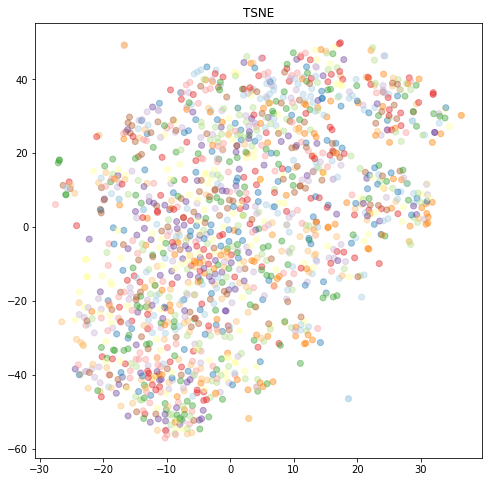

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
# Create the figure
fig = plt.figure( figsize=(8,8) )
ax = fig.add_subplot(1, 1, 1, title='TSNE' )
# Create the scatter
ax.scatter(
    x=tsne_results[:,0], 
    y=tsne_results[:,1], 
    c=df['label'], 
    cmap=plt.cm.get_cmap('Paired'), 
    alpha=0.4)
plt.show()

In [ ]:
## not working
### model tf 2.4 to tf2.1 for pc

# %%capture
# !pip3 install 
# !virtualenv env
# pathenv = '/content/env/bin/activate'

# model_json = model.to_json()
# with open("model.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# model.save_weights("modelweight.h5")
# print("Saved model to disk")

Saved model to disk


In [ ]:
# %%capture
# !pip3 install tensorflow==2.1
# model_pc = get_model()
# model_pc.load_weights('model.h5')
# model_pc.save('model_pc.h5')

# from google.colab import files
# files.download('model_pc.h5')